In [ ]:

from keras.preprocessing import sequence
import keras
import tensorflow as tf
import os
import numpy as np
import pandas as pd

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Twitter_Data.csv to Twitter_Data.csv


In [ ]:
df = pd.read_csv('Twitter_Data.csv')

In [ ]:
df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [ ]:
df.dropna(inplace = True)

In [ ]:
df.isnull().sum()

clean_text    0
category      0
dtype: int64

In [ ]:
df['category'].value_counts()

 1.0    72249
 0.0    55211
-1.0    35509
Name: category, dtype: int64

In [ ]:
positive = df[df['category']== 1.0]
negative = df[df['category']== -1.0]
neutral = df[df['category']== 0.0]

In [ ]:
df = pd.concat([positive.head(35000), negative.head(35000),neutral.head(35000)])
df.head()

,clean_text,category
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
8,with upcoming election india saga going import...,1.0
9,gandhi was gay does modi,1.0


In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)
df.head()

,clean_text,category
13760,remember during modi meeting was behaving alia...,-1.0
62846,fugitive diamond merchant nirav modi will appl...,0.0
44725,what the proof please before this question com...,1.0
44481,just after watching deliver the speech was gre...,0.0
75295,expecting some matured leadership conversation...,-1.0


In [ ]:
!pip install text_hammer
import text_hammer as th


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.11.2
    Uninstalling beautifulsoup4-4.11.2:
      Successfully uninstalled beautifulsoup4-4.11.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.33 requires beautifulsoup4>=4.11.1, but you have beautifulsoup4 4.9.1 which is incompatible.


In [ ]:
%%time
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x))
    #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

CPU times: user 4.12 ms, sys: 0 ns, total: 4.12 ms
Wall time: 12.8 ms


tqdm can be applied to any iterable in Python, like lists, arrays, or data generators. It provides a progress bar that updates in real-time, giving you a visual indication of how much progress has been made.

In [ ]:
df = text_preprocessing(df, 'clean_text')

  0%|          | 0/105000 [00:00<?, ?it/s]

  0%|          | 0/105000 [00:00<?, ?it/s]

  0%|          | 0/105000 [00:00<?, ?it/s]

  0%|          | 0/105000 [00:00<?, ?it/s]

  0%|          | 0/105000 [00:00<?, ?it/s]

  0%|          | 0/105000 [00:00<?, ?it/s]

  0%|          | 0/105000 [00:00<?, ?it/s]

In [ ]:
df.head()

,clean_text,category
13760,remember during modi meeting was behave alia s...,-1.0
62846,fugitive diamond merchant nirav modi will appl...,0.0
44725,what the proof please before this question com...,1.0
44481,just after watching deliver the speech was gre...,0.0
75295,expect some mature leadership conversation you...,-1.0


In [ ]:
vocab_size = 40000
# this means 40000 unique words can be taken
embedding_dim = 64
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'


In [ ]:
category = {
            1.0 : 1,
             0.0 : 0,
             -1.0 : 2
            }

In [ ]:
df['category'] = df['category'].map(category)

The above process is important if we are using sparse_categorical_crossentropy as it has a label range of [0, 3). And -1 is out of its range.

In [ ]:
#df = df.fillna(-1)   to fill -1 in place of NaN wherever it comes in the category column

In [66]:
df.head()

,clean_text,category
13760,remember during modi meeting was behave alia s...,2
62846,fugitive diamond merchant nirav modi will appl...,0
44725,what the proof please before this question com...,1
44481,just after watching deliver the speech was gre...,0
75295,expect some mature leadership conversation you...,2


In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['category'], test_size=0.2, random_state=1)

In [68]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok, lower=True)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

The purpose of the tokenizer is to convert text data into a numerical format that can be fed into a machine learning model. It learns a mapping from words to indices based on the training data.
If you were to include the test data in the training of the tokenizer, it could introduce a form of data leakage. This means information from the test set could "leak" into the training process, potentially leading to overly optimistic performance estimates.
The goal of a machine learning model is to generalize well to unseen data. By training the tokenizer solely on the training data, you are ensuring that the model learns a representation that is optimized for generalization.

The parameter lower=True specifies that the tokenizer should convert all text to lowercase before processing it. This means that during tokenization, any uppercase letters in the text will be converted to their lowercase equivalents.

In [69]:
X_train = pad_sequences(X_train, padding=padding_type)
X_train.shape

(84000, 51)

In this line, pad_sequences is applied to X_train without specifying the maxlen parameter. In this case, the maxlen defaults to the length of the longest sequence in X_train.
Here in (84000, 51) 51 is that max length


In [70]:
M = X_train.shape[1]
X_test = pad_sequences(X_test, maxlen=M, padding=padding_type, truncating=trunc_type)
X_test.shape

(21000, 51)

By specifying maxlen=M, you are ensuring that the sequences in X_test are padded to the same length as the longest sequence in X_train.

**while LSTM layers have the ability to handle sequences of variable lengths, the decision to pad or truncate sequences depends on the specific requirements of the model, the nature of the data, and the efficiency considerations during training. It's a balance between allowing flexibility and maintaining efficient processing.**

In [71]:
y_test.shape

(21000,)

In [72]:
y_train.shape

(84000,)

In [73]:
word_index

{'<OOV>': 1,
 'modi': 2,
 'the': 3,
 'and': 4,
 'for': 5,
 'not': 6,
 'have': 7,
 'you': 8,
 'do': 9,
 'that': 10,
 'this': 11,
 'will': 12,
 'india': 13,
 'are': 14,
 'with': 15,
 'they': 16,
 'but': 17,
 'all': 18,
 'was': 19,
 'say': 20,
 'his': 21,
 'can': 22,
 'people': 23,
 'from': 24,
 'what': 25,
 'who': 26,
 'bjp': 27,
 'give': 28,
 'like': 29,
 'your': 30,
 'congress': 31,
 'now': 32,
 'only': 33,
 'make': 34,
 'vote': 35,
 'narendra': 36,
 'our': 37,
 'why': 38,
 'election': 39,
 'govt': 40,
 'get': 41,
 'its': 42,
 'about': 43,
 'take': 44,
 'one': 45,
 'year': 46,
 'just': 47,
 'he': 48,
 'country': 49,
 'when': 50,
 'know': 51,
 'their': 52,
 'time': 53,
 'nation': 54,
 'come': 55,
 'how': 56,
 'should': 57,
 'indian': 58,
 'want': 59,
 'rahul': 60,
 'any': 61,
 'see': 62,
 'after': 63,
 'credit': 64,
 'modis': 65,
 'space': 66,
 'even': 67,
 'out': 68,
 'also': 69,
 'which': 70,
 'then': 71,
 'against': 72,
 'power': 73,
 'there': 74,
 'good': 75,
 'work': 76,
 'governme

In [ ]:
# from sklearn.model_selection import train_test_split
# y=pd.get_dummies(df['category'])
# X_train, X_test, y_train, y_test = train_test_split(df['clean_text'],y , test_size = 0.3, random_state = 42)

pd.get_dummies is a function provided by the Pandas library in Python. It is used for one-hot encoding categorical variables in a DataFrame. One-hot encoding is a technique used in machine learning to convert categorical data (text or labels) into a numerical format that can be provided to machine learning algorithms to improve model performance. IMP when we are using categorical_crossentropy loss function

Use categorical_crossentropy when your targets are one-hot encoded. This is common in multi-class classification tasks. For example, for three classes, a sample with label "Class 2" would be represented as [0, 1, 0].

Use sparse_categorical_crossentropy when your targets are integers (e.g., class indices). This is common in tasks where you have integer-encoded labels. For example, 0 for Class 0, 1 for Class 1, etc.

--- ---

 The embedding layer itself doesn't explicitly decide if two words have similar
meanings. Instead, it learns to represent words in a continuous vector space in such a way that words with similar meanings or usage tend to have similar vector representations.

One of the key benefits of the GlobalAveragePooling1D layer is that it reduces the spatial dimensions of the input data while retaining its essential information. For example, if you have a sequence of words represented by embeddings, this layer computes the average of the embeddings across all time steps, resulting in a single vector. Global Average Pooling may not always be suitable for tasks where spatial relationships or positional information are crucial, as it discards this information. It can act as a regularizer by preventing the model from memorizing noise or low-level details. Originally the data is three-dimensional (batch_size x steps x features). GlobalAveragePooling1D makes it (batch_size x features).

In [102]:
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Dense,GlobalMaxPooling1D,Embedding
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten,LSTM
from tensorflow.keras.layers import Dropout
from keras.preprocessing import sequence

model = Sequential()
D = 20
model.add(Embedding(vocab_size+1, D, input_length = M))
model.add(Conv1D(256, 3, activation = 'relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128,3,activation = 'relu'))
model.add(Dropout(0.2))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(32,return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(250,activation = 'relu'))
model.add(Dense(3,activation = 'softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 51, 20)            800020    
                                                                 
 conv1d_13 (Conv1D)          (None, 49, 256)           15616     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 16, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 14, 128)           98432     
                                                                 
 dropout_17 (Dropout)        (None, 14, 128)           0         
                                                                 
 lstm_6 (LSTM)               (None, 14, 64)            49408     
                                                      

Suppose you have a vocabulary with 10,000 unique words (V=10000). You would set input_dim=10001 in the Embedding layer, because you have 10,000 actual words (indexed from 0 to 9999) and one additional index reserved for the OOV token.

In summary, setting input_dim to be equal to Vocab_size can work if you're confident that all words in the testing and real-world data are present in the training data. However, it's generally recommended to include a special OOV token by setting input_dim to (Vocab_size+1) to handle any unforeseen words that may appear. This approach allows for better generalization and robustness of the model.

In [104]:
#EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

If you don't specify a batch size in the model.fit() function, it will default to 32. This means that the training data will be divided into batches of 32 samples each, and the model's weights will be updated after processing each batch.

In [105]:
!pip install tensorflow-addons

In [106]:
import tensorflow_addons as tfa
optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [123]:
num_epochs = 20
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test),batch_size = 64, verbose = 1) #,callbacks= [es, mc]

Epoch 1/20
1313/1313 [==============================] - 103s 78ms/step - loss: 0.0655 - accuracy: 0.9787 - val_loss: 0.5709 - val_accuracy: 0.8618
Epoch 2/20
1313/1313 [==============================] - 104s 79ms/step - loss: 0.0566 - accuracy: 0.9818 - val_loss: 0.6426 - val_accuracy: 0.8618
Epoch 3/20
1313/1313 [==============================] - 104s 79ms/step - loss: 0.0498 - accuracy: 0.9839 - val_loss: 0.6397 - val_accuracy: 0.8613
Epoch 4/20
1313/1313 [==============================] - 101s 77ms/step - loss: 0.0456 - accuracy: 0.9856 - val_loss: 0.7377 - val_accuracy: 0.8495
Epoch 5/20
1313/1313 [==============================] - 108s 82ms/step - loss: 0.0418 - accuracy: 0.9868 - val_loss: 0.7695 - val_accuracy: 0.8475
Epoch 6/20
1313/1313 [==============================] - 101s 77ms/step - loss: 0.0378 - accuracy: 0.9880 - val_loss: 0.7260 - val_accuracy: 0.8457
Epoch 7/20
1313/1313 [==============================] - 103s 78ms/step - loss: 0.0372 - accuracy: 0.9881 - val_loss: 0

In [124]:
y_pred=model.predict(X_test)
y_pred

657/657 [==============================] - 8s 12ms/step


array([[3.1057408e-04, 9.9944246e-01, 2.4684216e-04],
       [2.2853652e-09, 1.5150850e-12, 9.9999994e-01],
       [6.4479359e-06, 2.5959777e-08, 9.9999350e-01],
       ...,
       [1.9461205e-02, 9.7928143e-01, 1.2573963e-03],
       [3.4639845e-03, 4.0140349e-02, 9.5639575e-01],
       [3.4232889e-03, 9.4997460e-01, 4.6602134e-02]], dtype=float32)

In [125]:
import numpy as np
y_pred=np.argmax(y_pred,axis=1)
y_pred

array([1, 2, 2, ..., 1, 2, 1])

Text(50.722222222222214, 0.5, 'y_pred')

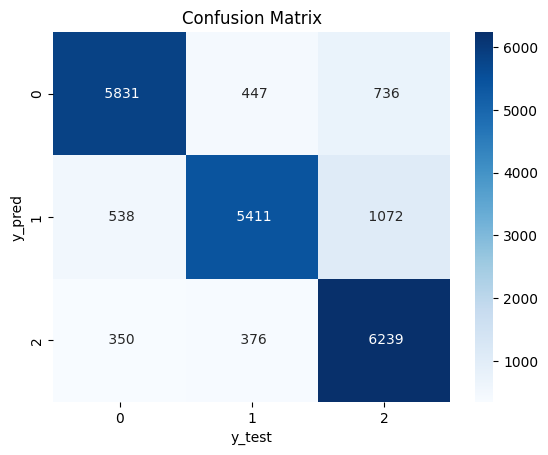

In [126]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
cm=confusion_matrix(y_test,y_pred)
ax=sns.heatmap(cm,annot=True,cmap='Blues',fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred')

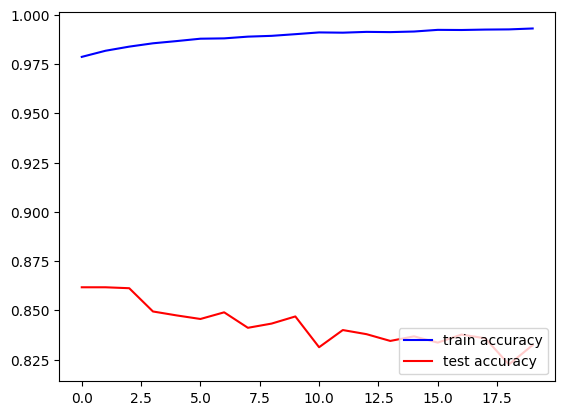

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(history.history['accuracy'],c='b',label='train accuracy')
plt.plot(history.history['val_accuracy'],c='r',label='test accuracy')
plt.legend(loc='lower right')
plt.show()

In [128]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy  : {:.4f}'.format(accuracy))
print('loss : {:.4f}'.format(loss))

Accuracy  : 0.8324
loss : 1.2258


In [137]:
input="modi is bad"
input_seq=tokenizer.texts_to_sequences([input])
padded=pad_sequences(input_seq, maxlen=51, padding='post', truncating='post')

In [138]:
padded.shape

(1, 51)

In [139]:
pred=model.predict(padded)

1/1 [==============================] - 0s 38ms/step


In [140]:
print(pred)

[[1.2815108e-04 2.8618256e-06 9.9986899e-01]]


In [142]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [143]:
file_path = '/content/drive/MyDrive/twitterdf.csv'
df.to_csv(file_path, index=False)

In [160]:
import os

# Define the path for your project directory
project_dir = '/content/drive/MyDrive/CNN_LSTMsent/'

# Create the directory if it doesn't exist
os.makedirs(project_dir, exist_ok=True)

In [166]:
file_path = '/content/drive/MyDrive/CNN_LSTMsent/twitterdf.csv'
df.to_csv(file_path, index=False)

In [167]:
model.save("/content/drive/MyDrive/CNN_LSTMsent/my_model")

In [ ]:
import shutil

# Define the folder path you want to archive
folder_to_archive = '/content/drive/My Drive/CNN_LSTMsent/'

# Define the output archive file name and format (e.g., zip)
output_archive = '/content/drive/My Drive/archive'

# Create the archive
shutil.make_archive(output_archive, 'zip', folder_to_archive)


'/content/drive/My Drive/archive.zip'